In [1]:
import os
import torch
import random
import numpy as np
import pickle

from PIL import Image
from pathlib import Path
import diffusers


ML_TASK_SERVER_PTH = '/home/user/ml_task_server/' # Path to ml_task_server

os.chdir(ML_TASK_SERVER_PTH)

import leditsplusplus
from leditsplusplus.leditspp import LEditsPPPipelineStableDiffusion
from torchvision.transforms.functional import pil_to_tensor
from torchvision.transforms.functional import normalize
from facexlib.utils.misc import img2tensor
from leditsplusplus.face_editing_helper import FaceEditingHelper
from utils import timeit, seed_everything
from leditsplusplus.detail_restoration import restore_details
from leditsplusplus.editor import Editor
from diffusers import AutoencoderKL, DPMSolverMultistepScheduler ,DiffusionPipeline, StableDiffusionPipeline
from leditsplusplus.leditspp import LEditsPPPipelineStableDiffusion
from transformers import CLIPTokenizer
from diffusers import DDPMScheduler
from compel import Compel


# General params

REPO_PTH = '/home/user/stable-diffusion-2-1' # Path baseline SD model
VAE_PTH = '/home/user/stable-diffusion-2-1/vae' # Path to VAE to use
LORA_PTH = '/home/user/kohya-trainer/fine_tune/output/exp_locon_v2_dataset_hq_64_64_16_1_10_reps_-000024.safetensors' # Path to lora to use
EDITOR_IMAGE_CACHE_ROOT_DIR = '/home/user/ml_task_server/image_cache/editor' # Path to image cache dir 
VARIANT = "fp16"
USE_LORA = True # False to use SD without lora
LORA_SCALE = 0.5 # Lora scale param - higher gives more weight to Lora while inference
ADAPTER_NAME = 'Glam' # Don't change

FACE_PARSE = None
FACE_DET = None

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num = 10 # For cache

# Generation params

edit_prompt = "Glam, a woman with glam makeup, glam look, 4k, the best quality, masterpiece, glam thick eyebrows, glam thick eyelashes, soft eyelashes, glam blush"
edit_guidance_scale = 10.0

edit_warmup_steps = 3
edit_threshold = 0.0
num_inversion_steps = 10

skip = 0.8
seed = 47

eye_intensity = 0
lip_intensity = 0

detail_restoration_amount = 0.4


vae= AutoencoderKL.from_pretrained(VAE_PTH, torch_dtype=torch.float16, use_safetensors=True)

/home/user/mambaforge/envs/ledit/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
TEST_IMG_PTH = "/home/user/kohya-trainer/image_2_test_5.png" 

torch.cuda.empty_cache()
image_id = f"{random.randint(0, np.iinfo(np.int32).max) + num}"
image = Image.open(TEST_IMG_PTH)
num+= 1 # Increment image num 

#### Clean cache after all tests to avoid image_id errors!!! ####


args = [image,
        image_id,
        edit_prompt,
        edit_guidance_scale, 
        edit_warmup_steps,
        edit_threshold, 
        num_inversion_steps, 
        skip, 
        seed, 
        eye_intensity,
        lip_intensity, 
        detail_restoration_amount]


In [3]:
# Refactored Editor class for Lora usage

class Editor:
    def __init__(self,
                 vae: AutoencoderKL,
                 face_parse,
                 face_det,
                use_lora,
                lora_scale = None,
                lora_path = None,
                adapter_name = None,
                repo_id = None):
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        repo_id = REPO_PTH
        use_safetensors=True
        variant = "fp16"
        
        scheduler = DPMSolverMultistepScheduler.from_pretrained(
            repo_id,
            subfolder="scheduler",
            algorithm_type="sde-dpmsolver++",
            variant=variant,

        )

        pipe = StableDiffusionPipeline.from_pretrained(
            repo_id,
            vae=vae,
            scheduler=scheduler,
            safety_checker=None,
            feature_extractor=None,
            requires_safety_checker=False,
            torch_dtype=torch.float16,
            use_safetensors=True,
            variant=variant,
            
        ).to(self.device)

        self.use_lora = use_lora
        self.lora_scale = lora_scale
        self.lora_path = lora_path
        self.adapter_name = adapter_name
        
        self.pipe = pipe.to(self.device)
        
        if self.use_lora:
            #self.pipe.load_lora_weights('/home/user/kohya-trainer/fine_tune/output/exp_locon_v2_dataset_hq_64_64_16_1_10_reps_-000024.safetensors', adapter_name="Glam")
            self.pipe.load_lora_weights(self.lora_path,
                                        adapter_name = self.adapter_name)
            
            self.pipe.set_adapters(self.adapter_name)
            self.pipe.fuse_lora(lora_scale = self.lora_scale)
            
        self.pipe = LEditsPPPipelineStableDiffusion.from_pipe(self.pipe)
        self.compel = Compel(tokenizer=pipe.tokenizer, text_encoder=pipe.text_encoder)
        self.face_helper = FaceEditingHelper(face_size=768, face_det=face_det, face_parse=face_parse)

    @timeit
    def invert(self, image: Image, image_id: str, num_inversion_steps: int, skip: float, generator: torch.Generator):
        zs, init_latents = get_cached_inversion_output(image_id)
        if zs is not None and init_latents is not None:
            self.pipe.zs = zs
            self.pipe.init_latents = init_latents
        else:
            self.pipe.invert(
                image=image,
                source_guidance_scale=0,
                num_inversion_steps=num_inversion_steps,
                skip=skip,
                generator=generator,
            )
            cache_inversion_output(image_id, self.pipe.zs, self.pipe.init_latents)

    @timeit
    @torch.no_grad()
    def parse_face(self, image: Image, image_id: str):
        face_parse_mask = get_cached_face_parse_mask(image_id=image_id)
        if face_parse_mask is not None:
            return face_parse_mask

        image = image.resize((512, 512), Image.Resampling.LANCZOS)
        image = np.array(image).astype(np.float32) / 255.0
        image = img2tensor(image, bgr2rgb=False, float32=True)
        normalize(image, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True)
        image = torch.unsqueeze(image, 0).to(self.device)
        face_parse_mask = self.face_helper.face_parse(image)[0]
        face_parse_mask = face_parse_mask.argmax(dim=1).squeeze().cpu().numpy()
        cache_face_parse_mask(image_id=image_id, face_parse_mask=face_parse_mask)
        return face_parse_mask

    def make_user_mask(self, image: Image, image_id: str, eye_intensity: float, lip_intensity: float):
        face_parse_mask = self.parse_face(image=image, image_id=image_id)
        mask = np.zeros(face_parse_mask.shape)
        eye_intensity = int(255 * eye_intensity)
        lip_intensity = int(255 * lip_intensity)
        MASK_COLORMAP = [
            0,  # background
            255,  # skin
            255,  # nose
            255,  # eye_g
            eye_intensity,  # l_eye
            eye_intensity,  # r_eye
            255,  # l_brow
            255,  # r_brow
            0,  # l_ear
            0,  # r_ear
            0,  # mouth

            lip_intensity,  # u_lip
            lip_intensity,  # l_lip
            
            0,  # hair
            0,  # hat
            0,  # ear_r
            0,  # neck_l
            0,  # neck
            0,  # cloth
            
            
        ]
        for idx, color in enumerate(MASK_COLORMAP):
            mask[face_parse_mask == idx] = color

        width, height = image.size
        user_mask = pil_to_tensor(Image.fromarray(mask).resize((int(width / 8), int(height / 8)))) / 255.0
        return user_mask, face_parse_mask

    @timeit
    def align_image(self, image: Image, image_id: str):
        self.face_helper.read_image(image)
        aligned_image, landmarks = get_cached_alignement_data(image_id=image_id)
        if aligned_image is not None and landmarks is not None:
            self.face_helper.all_landmarks = landmarks
            self.face_helper.align_warp_face()
            return aligned_image

        self.face_helper.get_face_landmarks()
        self.face_helper.align_warp_face()
        aligned_image = Image.fromarray(self.face_helper.cropped_faces[0])
        cache_alignement_data(image_id=image_id, aligned_image=aligned_image, landmarks=self.face_helper.all_landmarks)
        return aligned_image

    def edit(
        self,
        image: Image,
        image_id: str,
        edit_prompt: str,
        edit_guidance_scale: float,
        edit_warmup_steps: int,
        edit_threshold: float,
        num_inversion_steps: int,
        skip: float,
        seed: int,
        eye_intensity: float,
        lip_intensity: float,
        detail_restoration_amount: float,
    ):
        aligned_image = self.align_image(image=image, image_id=image_id)
        generator = seed_everything(seed=seed, device=self.device)
        self.invert(
            image=aligned_image,
            image_id=image_id,
            num_inversion_steps=num_inversion_steps,
            skip=skip,
            generator=generator,
        )
        
        
        user_mask, face_parse_mask = self.make_user_mask(
            image=aligned_image, image_id=image_id, eye_intensity=eye_intensity, lip_intensity=lip_intensity
        )
                
        editing_prompt_embeds = self.compel(edit_prompt)
        neg_prompt_embeds = self.compel(""" Bad quality, 
                                        distorted details, 
                                        distorted face, 
                                        distorted lips, 
                                        distorted eyes,
                                        distorted nose, 
                                        wrinkles,
                                        asymmetrical makeup, 
                                        oversaturation, 
                                        artefacts,
                                        red skin,
                                        acne,
                                        freckles on face, 
                                        skin irregularities,
                                        lowres,  
                                        poorly drawn face, 
                                        deformed, 
                                        blurry, 
                                        jpeg artifacts, 
                                        ugly,
                                        ligh spots,
                                        light flares,
                                        (worst quality:1.4), 
                                        (low quality:1.4)
                                        """ ) 
        
        result_image = self.pipe(
            generator=generator,
            editing_prompt_embeds = editing_prompt_embeds,
            
            negative_prompt_embeds = neg_prompt_embeds if self.use_lora else None,
            
            reverse_editing_direction=[False],
            edit_warmup_steps=[edit_warmup_steps],
            edit_guidance_scale=[edit_guidance_scale],
            edit_threshold=[edit_threshold],
            user_mask=user_mask,            
#            cross_attention_kwargs={"scale": 1},
#            strength=0.5,
#            cross_attention_kwargs={"scale": 0.9},
#            strength=0.9,
#            num_inference_steps=50,
#            guidance_scale=12,
            
            use_intersect_mask=False,
        ).images[0]
        self.face_helper.add_restored_face(result_image)
        self.face_helper.add_face_parse_mask(face_parse_mask)
        result_image = self.face_helper.paste_faces_to_input_image()
        self.face_helper.clean_all()
        result_image, _ = restore_details(image, result_image, detail_restoration_amount)
        return result_image, aligned_image


def get_cached_inversion_output(image_id: str):
    path = f"{EDITOR_IMAGE_CACHE_ROOT_DIR}/{image_id}"
    try:
        with open(f"{path}/zs", "rb") as f:
            zs = torch.load(f)

        with open(f"{path}/init_latents", "rb") as f:
            init_latents = torch.load(f)

        return zs, init_latents
    except Exception as e:
        return None, None


def cache_inversion_output(image_id: str, zs: torch.tensor, init_latents: torch.tensor):
    path = f"{EDITOR_IMAGE_CACHE_ROOT_DIR}/{image_id}"
    Path(path).mkdir(parents=True, exist_ok=True)
    try:
        with open(f"{path}/zs", "wb") as f:
            torch.save(zs, f)

        with open(f"{path}/init_latents", "wb") as f:
            torch.save(init_latents, f)
    except Exception as e:
        print(e)


def get_cached_face_parse_mask(image_id: str):
    path = f"{EDITOR_IMAGE_CACHE_ROOT_DIR}/{image_id}"
    try:
        with open(f"{path}/face_parse_mask", "rb") as f:
            return pickle.load(f)
    except Exception as e:
        return None


def cache_face_parse_mask(image_id: str, face_parse_mask: np.array):
    path = f"{EDITOR_IMAGE_CACHE_ROOT_DIR}/{image_id}"
    Path(path).mkdir(parents=True, exist_ok=True)
    try:
        with open(f"{path}/face_parse_mask", "wb") as f:
            pickle.dump(face_parse_mask, f)
    except Exception as e:
        print(e)


def get_cached_alignement_data(image_id: str):
    path = f"{EDITOR_IMAGE_CACHE_ROOT_DIR}/{image_id}"
    try:
        with open(f"{path}/aligned_image", "rb") as f:
            image = pickle.load(f)

        with open(f"{path}/landmarks", "rb") as f:
            landmarks = pickle.load(f)

        return Image.fromarray(image).convert("RGB"), landmarks
    except Exception as e:
        return None, None


def cache_alignement_data(image_id: str, aligned_image: Image, landmarks: np.array):
    path = f"{EDITOR_IMAGE_CACHE_ROOT_DIR}/{image_id}"
    Path(path).mkdir(parents=True, exist_ok=True)
    try:
        with open(f"{path}/aligned_image", "wb") as f:
            pickle.dump(np.array(aligned_image, dtype=np.uint8), f)

        with open(f"{path}/landmarks", "wb") as f:
            pickle.dump(landmarks, f)
    except Exception as e:
        print(e)
        
def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

In [4]:
editor = Editor(vae = vae,
               face_parse = FACE_PARSE,
               face_det = FACE_DET,
               repo_id = REPO_PTH,
               use_lora= USE_LORA,
                lora_scale = LORA_SCALE,
                lora_path = LORA_PTH,
                adapter_name = ADAPTER_NAME)


Loading pipeline components...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]
/home/user/mambaforge/envs/ledit/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/mambaforge/envs/ledit/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/user/mambaforge/envs/ledit/lib/python3.11/site-packages/facexlib/detection/__init__.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to const

In [6]:
res = editor.edit(*args)

get_face_landmarks took 0.24 seconds
align_warp_face took 0.028 seconds
align_image took 0.3 seconds


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.55it/s]


invert took 1.3 seconds
parse_face took 0.05 seconds


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.34it/s]


paste_faces_to_input_image took 0.11 seconds
restore_details took 0.022 seconds


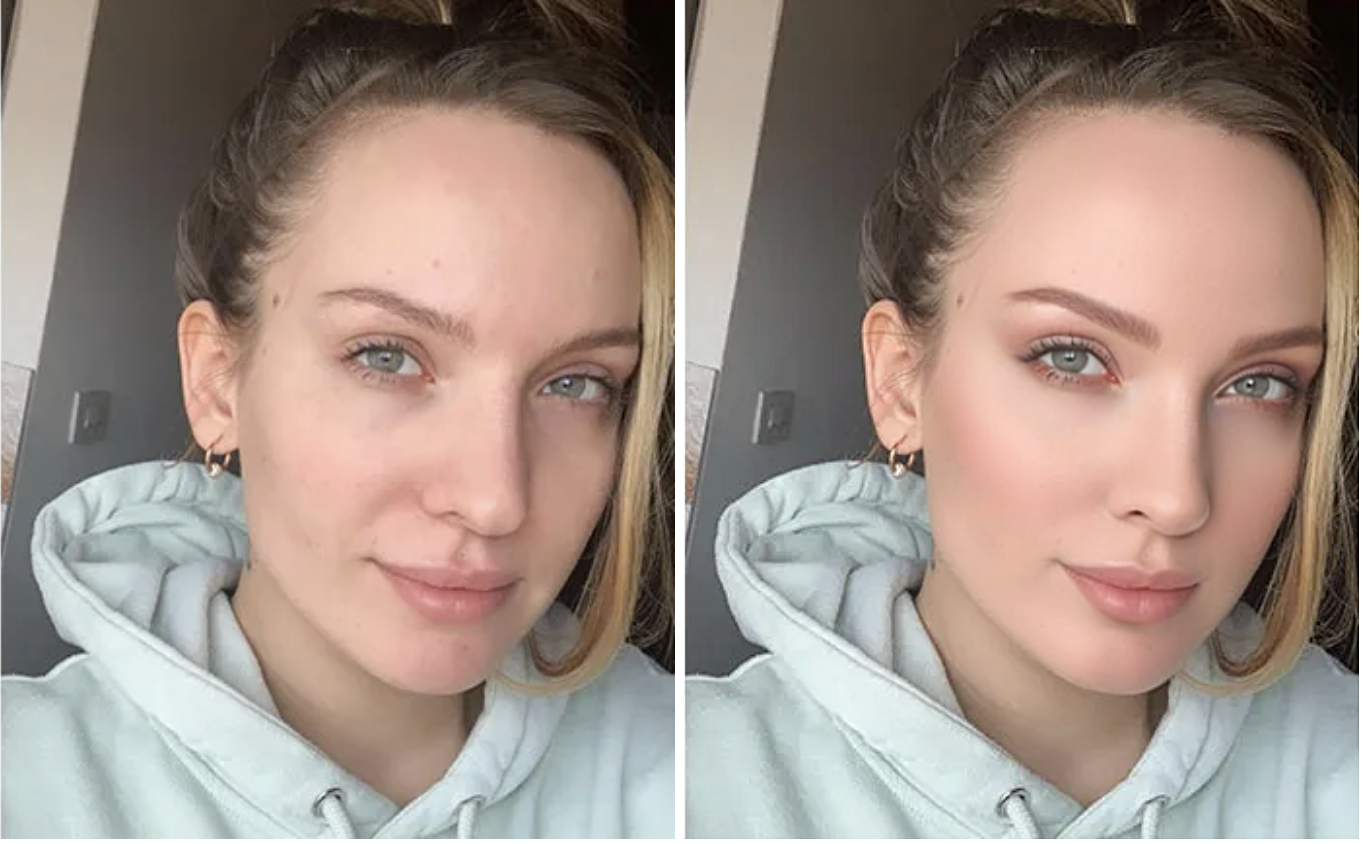

In [7]:
get_concat_h(image, res[0])